In this notebook we show how to prepare data for a multivariate ts case with multiple exogenous variables. Depending on how the original structure of your data is, there might be different ways for achieving this. Here two different scenarios will be shown from where the creation of the feat_dynamic_real with multiple features is presented:

1) The relevant ts features (and targets) can be found in seperated columns, which need to be extracted.

2) The relevant ts target and features are stacked for each ID having a df with fewer columns but more rows

The main idea to understand is that the final feat_dynamic_real has to be in the following shape using GluonTS:
- (number of time-series, number of features, number of steps)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

from pts.model.deepar import DeepAREstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts import time_feature
import json
from itertools import islice
from gluonts.dataset.field_names import FieldName

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
# Load data

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv'
df = pd.read_csv(url, index_col=0)
df.shape

(19735, 28)

In [3]:
# check columns:

df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2'], dtype='object')

In [4]:
# define target and features:

target_cols = [col for col in df.columns if 'T' in col and len(col) <=2]
features_room = [col for col in df.columns if 'RH' in col and len(col) <=4]
features_outside = list(filter(lambda x:x not in target_cols+features_room, 
                               df.columns))

In [5]:
# normalize input data:

input_cols = features_room+features_outside

norm_df = df[input_cols].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
final_df = pd.concat([df[target_cols], norm_df], ignore_index=False, sort=False, axis=1)

In [6]:
# return values:

target = final_df[target_cols].T.values
f_room = final_df[features_room].T.values
f_outside = final_df[features_outside].T.values

#### Manual way of creating feat_dynamic_real

In [577]:
# We vstack the features that are indvididual
# for each room and the features from outside.
# In a final step, to create a 3-d array, we stack
# the individual arrays to get the final
# feat_dynamic_real:

a = np.vstack((f_room[0],f_outside))
b = np.vstack((f_room[1],f_outside))
c = np.vstack((f_room[2],f_outside))
d = np.vstack((f_room[3],f_outside))
e = np.vstack((f_room[4],f_outside))
f = np.vstack((f_room[5],f_outside))
g = np.vstack((f_room[6],f_outside))
h = np.vstack((f_room[7],f_outside))
i = np.vstack((f_room[8],f_outside))

feat_dynamic_real = np.stack((a,b,c,d,e,f,g,h,i))
feat_dynamic_real.shape

(9, 11, 19735)

#### Stacking using loop to get feat_dynamic_real

In [7]:
# Here we loop through the features creating 
# a dictand using the stacked values to create
# feat_dynamic_real in required shape:

dct = {}

for i,v in enumerate(range(len(f_room))):
    dct[i] = np.vstack((f_room[i],f_outside))
    
feat_dynamic_real = np.stack((list(dct.values()))) 
feat_dynamic_real.shape

(9, 11, 19735)

#### Multiple ts values in one column

In [8]:
# First we need to create a new df
# where the data is stacked.
# Having stacked data in few columns
# requires different way of data
# preperation:

df_t = final_df[target_cols].stack().reset_index().rename(columns={0:'T'}).sort_values(['level_1','date']).reset_index()
df_r = final_df[features_room].stack().reset_index().rename(columns={0:'Features'}).sort_values(['level_1','date']).reset_index()
df_t['F'] = df_r['Features'].copy()

for col in features_outside:
    b = []
    for i in range(len(target)):
        a = list(final_df[col])
        b = np.concatenate((b,a))
    df_t[col] = b.reshape(-1,1)
print(df_t.shape,
      df_t.columns)    

(177615, 15) Index(['index', 'date', 'level_1', 'T', 'F', 'Appliances', 'lights', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2'], dtype='object')


In [9]:
# look at the new df:

df_t.head()

,index,date,level_1,T,F,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,0,2016-01-11 17:00:00,T1,19.89,0.566187,0.046729,0.428571,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.265449,0.265449
1,9,2016-01-11 17:10:00,T1,19.89,0.541326,0.046729,0.428571,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.372083,0.372083
2,18,2016-01-11 17:20:00,T1,19.89,0.530502,0.037383,0.428571,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.572848,0.572848
3,27,2016-01-11 17:30:00,T1,19.89,0.524080,0.037383,0.571429,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.908261,0.908261
4,36,2016-01-11 17:40:00,T1,19.89,0.531419,0.046729,0.571429,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.201611,0.201611


In [10]:
# return number of ts and number of targets

number_ts = df_t.shape[0]/df_t.level_1.nunique()
number_targets = df_t.level_1.nunique()

print(number_ts, 'and',
      number_targets)

19735.0 and 9


In [11]:
# Extract target and stack:

dct_t = {}

for i in range(len(target)):
    dct_t[i] = df_t.loc[(number_ts*i):number_ts*(i+1)-1,'T']

target = np.stack(list(dct_t.values()))
target.shape    

(9, 19735)

In [12]:
# Extract features and stack:

dct_f = {}

for i in range(len(target)):
    dct_f[i] = df_t.loc[(number_ts*i):number_ts*(i+1)-1,['F']+features_outside].T

feat_dynamic_real = np.stack(list(dct_f.values()))
print(feat_dynamic_real.shape)
print('Note that the final shape of feat_dynamic_real is exactly as above.')

(9, 11, 19735)
Note that the final shape of feat_dynamic_real is exactly as above.


#### Defining parameters and training

In [13]:
# define the parameters of the dataset:

custom_ds_metadata = {
    'num_series': len(target), # because we have only one target ts
    'num_steps': df.shape[0], # defines the length of the ts
    'prediction_length': 250, # number of steps we want to predict
    'freq': '10min', # data is given in 10 min steps
    'start': [
        pd.Timestamp(df.index[0], freq='10m')
        for _ in range(df.shape[0])
    ]
}

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# Define fields used
# Here we define a dynamic_real value on top of the target
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:,:, :-custom_ds_metadata['prediction_length']]
            #feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

In [15]:
# check length of train and test
# to see if we have 9 ts:

print(len(train_ds),
      len(test_ds))

9 9


In [16]:
# Returning train and test dict:

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

print(test_entry.keys(), train_entry.keys())

dict_keys(['target', 'start', 'feat_dynamic_real', 'source']) dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])


/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq


/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


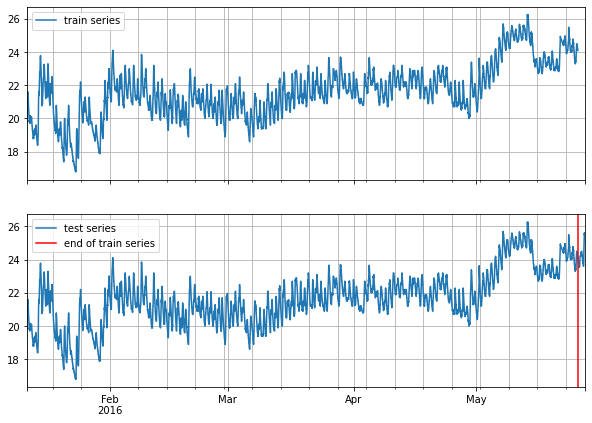

In [17]:
# plot train and testing data:

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq=custom_ds_metadata['freq'],
                            prediction_length=custom_ds_metadata['prediction_length'],
                            input_size=59,
                            num_layers=2,
                            num_cells=40,
                            use_feat_dynamic_real=True,
                            context_length=5*custom_ds_metadata['prediction_length'],
                            trainer=Trainer(epochs=5,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=64,
                                            batch_size=128,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/63 [00:00<?, ?it/s]

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
# Return forcast and compare with true values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 4*custom_ds_metadata['prediction_length']
    prediction_intervals = (10.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

for i in range(len(target)):    
    forecast_entry = forecasts[i]
    ts_entry = tss[i]
    plot_prob_forecasts(ts_entry, forecast_entry) 

In [ ]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))